## Movie Recommandation System

<p>In this file we're building a movie recommandation system using an intuive approach
where movies that are liked by the same users are connected</p>

In [5]:
### Import Libraires ###
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd

# url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
 
# with urlopen(url) as zurl:
#     with ZipFile(BytesIO(zurl.read())) as zfile:
#         zfile.extractall('.')

In [21]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [24]:
ratings.rename(columns={'item_id': 'movie_id'}, inplace=True)

In [25]:
ratings.info()
ratings.describe()
ratings['rating'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 55375 entries, 5 to 99996
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    55375 non-null  int64
 1   movie_id   55375 non-null  int64
 2   rating     55375 non-null  int64
 3   timestamp  55375 non-null  int64
dtypes: int64(4)
memory usage: 2.1 MB


rating
4    34174
5    21201
Name: count, dtype: int64

In [11]:
### Import the movies file ###
movies = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1', usecols = range (2), names = ['movie_id', 'title'])
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


<h5>We gonna check movies that have been like by the same user, note that movies ratings less than 4 are not important in this case of the study</h5>

In [26]:
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


<h5>Now let's count everytime two movies are liked by the same users, we will repeat this process for every users in the dataset</h5>

In [58]:
from collections import defaultdict

pairs = defaultdict(int)
for group in ratings.groupby("user_id"):
    ### Retrieve the user id and the number of movies that have been liked by the current user ### 
    # print(group[0]," + " + str(group[1].shape[0]))   
    ### Retrieve the list of movies that have been liked by the current user ###
    user_movies = list(group[1]["movie_id"])
    for i in range (len(user_movies)):
        for j in range(i + 1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1
# pairs

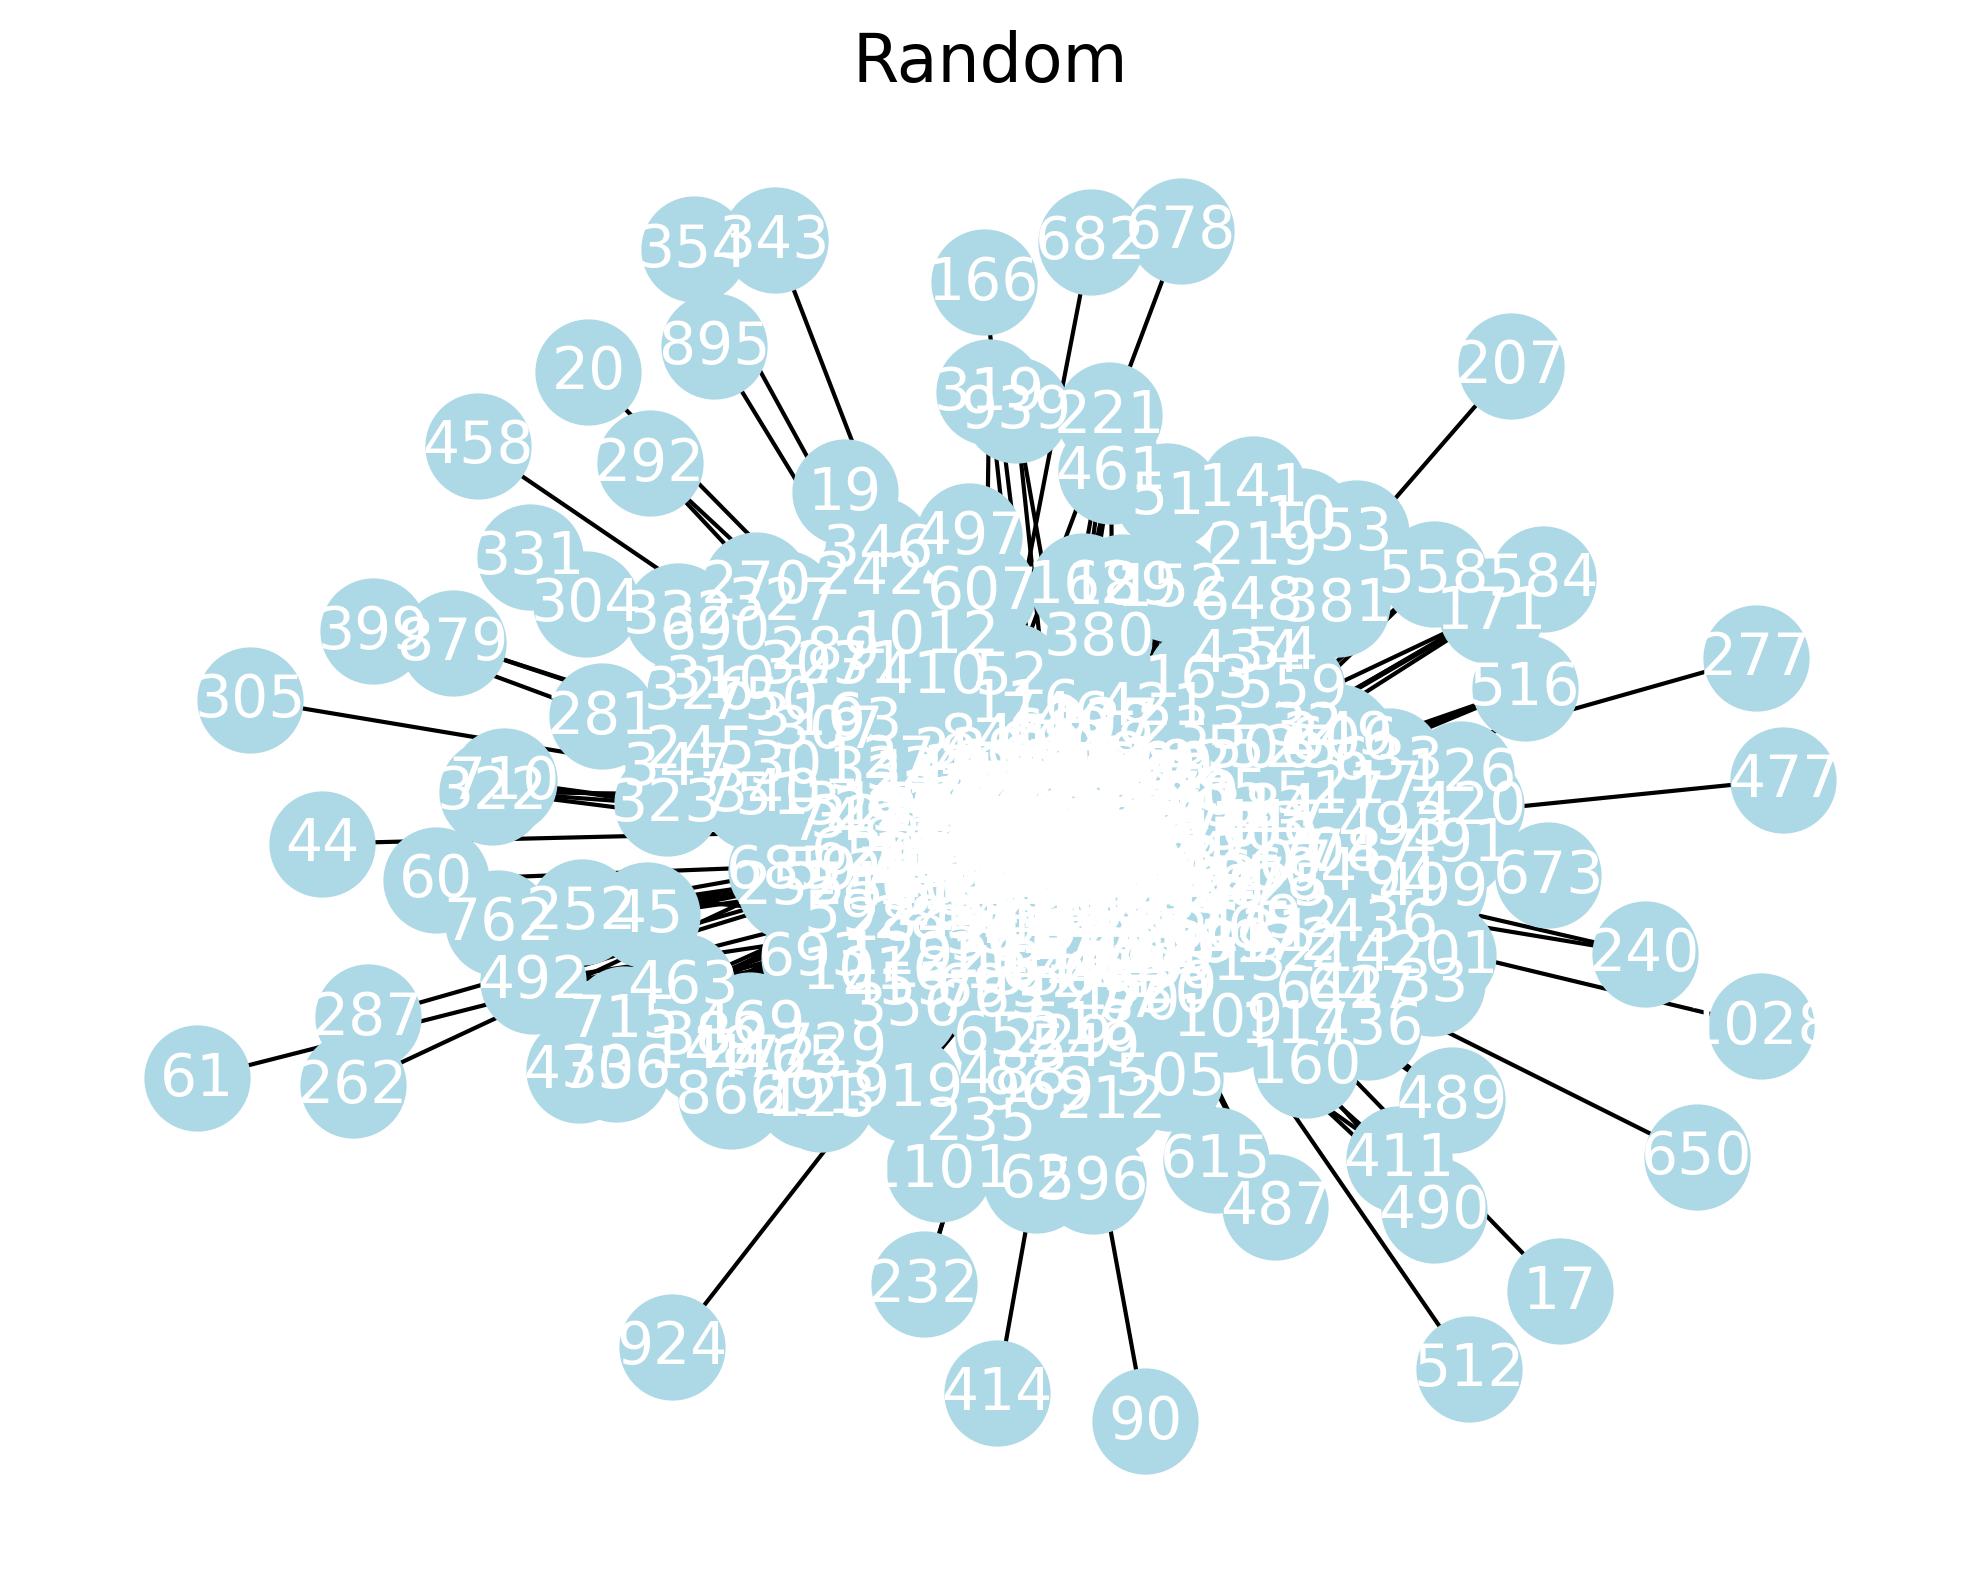

In [31]:
### Let's create the Graph ###
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]
    ### Add the nodes to the graph ###
    if score >= 20:        
        G.add_edge(movie1, movie2, weight = score)

### Let's visualize the graph ###
def draw_graph(G):
    pos = nx.spring_layout(G, seed = 0)
    plt.figure(dpi = 300)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, font_size=14, font_color='white', edge_color='black')
    plt.title("Random", fontsize=16)
    plt.show()
draw_graph(G)

In [35]:
### Let's create the Node2Vec model ###
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, workers=4, p=2, q=1)


Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


In [ ]:
### train the model ###
model = node2vec.fit(window=10, min_count=1, batch_words=4)
### Let's save the model ###
model.save("node2vec.model")

In [ ]:
### Let's load the model ###    
model = Word2Vec.load("node2vec.model")

<h5>Now our model is trained and saved we can build a recommandation function that will take a movie title as input</h5>

In [52]:
### recommantion function ###
def recommend_movies(movie):
    ### Get the movie_id from tthe title
    movie_id = movies[movies['title'] == movie].movie_id.values[0]

    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f"{title} - Similarity: {id[1]:.2f}")



In [53]:
### Call the function ###
recommend_movies('Star Wars (1977)')

Usual Suspects, The (1995) - Similarity: 0.70
Die Hard (1988) - Similarity: 0.69
Aliens (1986) - Similarity: 0.69
Terminator, The (1984) - Similarity: 0.67
Blues Brothers, The (1980) - Similarity: 0.65
